# Artificial Intelligence 🪐
# CA 3 - Clustering

# Amirali Shahriary (810100173)

## Introduction:
In this project, we are going to analyze the images of a number of different flowers by using clustering algorithms and try to put them in different categories using the data we have, so that after applying the clustering algorithm As much as possible, they are placed in their right cluster.

### necessarly libraries :

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.metrics import homogeneity_score, silhouette_score
from keras.models import Model


### Loading the Data:

The dataset used in this project includes a number of color photos of different types of flowers. There is also a csv file next to these images that contains the labels associated with these images. This CSV is used for evaluation section for these categories.

In [2]:
image_dir = "/home/amirali/Desktop/AI/CA3/flower_images"
csv_file = "/home/amirali/Desktop/AI/CA3/flower_labels.csv"
vgg_weights_path = '/home/amirali/Desktop/AI/CA3/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

data = pd.read_csv(csv_file)

### preprocessing and feature extraction:

In [3]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

images = []
for filename in data['file']:
    img_path = os.path.join(image_dir, filename)
    img = preprocess_image(img_path)
    images.append(img)

# Feature Extraction

vgg_model = VGG16(weights=vgg_weights_path, include_top=False)

def extract_features(img_array):
    features = vgg_model.predict(img_array)
    features = features.flatten()  # Flatten to use with clustering algorithms
    return features

X = np.array([extract_features(img) for img in images])


1/1 [==============================] - 0s 159ms/step


#### 1.What is the reason for feature extraction? Why don't we just read the pixels? Explain.

 The reason for feature extraction is to transform raw data (in this case, images represented by pixels) into a format that is suitable for machine learning algorithms. Directly using raw pixel values as features can be inefficient and may not capture the relevant information effectively. Feature extraction involves identifying and extracting meaningful patterns or features from the raw data that can better represent the underlying characteristics of the images.Features extracted from higher-level representations such as edges, textures, shapes, or colors can provide more discriminative information for tasks such as classification or clustering.

                                          ─── ⋆⋅☆⋅⋆ ── 

#### 2.Research about feature extraction from photos and briefly explain about its 3 techniques.

 Convolutional Neural Networks (CNNs): CNNs automatically learn hierarchical features from raw pixel data by applying convolutional filters and pooling operations. They have demonstrated state-of-the-art performance in various computer vision tasks, including image classification, object detection, and segmentation.
 
 Histogram of Oriented Gradients (HOG): This technique calculates the distribution of gradient orientations in localized portions of an image. It is commonly used for object detection and recognition tasks.
 
 Scale-Invariant Feature Transform (SIFT): SIFT detects and describes local features in images that are invariant to scale, rotation, and illumination changes. It is widely used in applications such as image stitching, object recognition, and matching.
 
                                          ─── ⋆⋅☆⋅⋆ ──     
                                          
                                        
#### 3.What pre-processing should be done on the images so that they are ready to enter the model?

 Resizing:need to be resized to a fixed size to ensure consistency in input dimensions.

 Normalization: Normalizing pixel values to a common scale 

 Data augmentation: Augmenting the dataset with transformations such as rotation, translation, flipping, or     cropping .

 Color space conversion: Converting images to a standard color space (e.g. RGB).

 Noise reduction: Apply filters or techniques to reduce noise in images.



### Clustering Implementation:

### K-Means Algorithm :

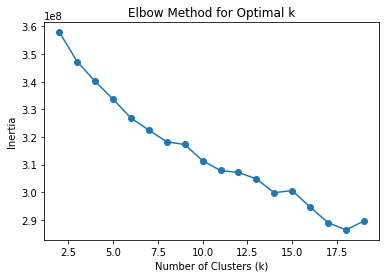

In [4]:
k_values = range(2, 20)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=75, n_init=10) 
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

with the below code, I previously found the best K and random_state but for increasing execution time suggest not running the below code and trusting what I found using this and manually hard code it! :)

In [ ]:
# optimal k using the elbow method
diff = np.diff(inertia_values)
diff_r = diff[1:] / diff[:-1]
k_optimal = k_values[np.argmin(diff_r) + 1]

print(f"Optimal k for K-means clustering: {k_optimal}")

# clustering with different random states
best_homogeneity_score = -1
best_random_state = None

for random_state in range(100):
    kmeans = KMeans(n_clusters=k_optimal, random_state=random_state)
    cluster_labels_kmeans = kmeans.fit_predict(X)
    homogeneity = homogeneity_score(data['label'], cluster_labels_kmeans)
    if homogeneity > best_homogeneity_score:
        best_homogeneity_score = homogeneity
        best_random_state = random_state

print(f"Best random state: {best_random_state}")

                                               ˚. ✦.˳·˖✶ ⋆.✧̣̇˚.

In [5]:
# Based on the plot, choose the optimal value of k and perform clustering

optimal_k = 18   
kmeans = KMeans(n_clusters=optimal_k, random_state=75)
cluster_labels_kmeans = kmeans.fit_predict(X)


/home/amirali/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### DB-Scan clustering :

In [6]:

pca = PCA(n_components=2)  
X_normalized = pca.fit_transform(X)

#different values of eps and min_samples
eps_values = np.arange(1, 101, 1)  
min_samples_values = range(2, 100)

best_score = -1  
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels_dbscan = dbscan.fit_predict(X_normalized)
        n_clusters = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
        if n_clusters > 1:  # at least 2 clusters should be formed
            homogeneity = homogeneity_score(data['label'], cluster_labels_dbscan)
            if homogeneity > best_score:
                best_score = homogeneity
                best_eps = eps
                best_min_samples = min_samples

if best_eps is not None and best_min_samples is not None:
    print(f"Best homogeneity score: {best_score}, eps: {best_eps}, min_samples: {best_min_samples}")

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    cluster_labels_dbscan = dbscan.fit_predict(X_normalized)
else:
    print("DBSCAN couldn't find clusters")


## if you want the eps and min_samples for the best Best silhouette score
#it will be silhouette score: 0.5097119212150574, eps: 99, min_samples: 5

Best homogeneity score: 0.38569751190481755, eps: 32, min_samples: 2


####  4.Explain about the Means-K and DBSCAN methods and the advantages and disadvantages of these methods.

#### KMeans:

KMeans clustering starts by randomly assigning each data point to one of the K clusters. Then, it computes the centroid of each cluster and reassigns each data point to the cluster with the closest centroid. This process repeats iteratively until the cluster assignments for each data point no longer change.

###### Advantages:

- Relatively simple to implement.

- Scales well to large datasets.

- Guarantees convergence.

###### Disadvantages:

- Works best for well-separated circular clusters of similar size.

- Requires manual selection of the number of clusters (K).

- Sensitive to initial cluster centroids.

- Not effective for clustering outliers.

                                          
                                                ⋆⁺‧₊☽◯☾₊‧⁺⋆
     

#### DBSCAN:

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm based on density, specifically the local density criterion, where clusters are formed by regions of high density separated by regions of low density.

In DBSCAN, each cluster has a considerably higher density of points than the areas outside of the cluster.

###### Advantages:

- Can discover arbitrarily shaped clusters.

- Can identify clusters completely surrounded by other clusters.

- Robust towards outlier detection (noise).

###### Disadvantages:

- Sensitive to clustering parameters such as minPoints and eps.

- Choosing a meaningful eps value can be challenging if the data distribution is not well understood.

- Fails to identify clusters if the density varies significantly or if the dataset is too sparse.



#### 5.What method have you used to find the most appropriate K in the Means-K method? Explain.

I used the Elbow Method to find the most appropriate value of K. The Elbow Method involves plotting the inertia (within-cluster sum of squares) against the number of clusters (K). The inertia measures how tightly the clusters are packed together.

By observing the plot, we look for the "elbow point," which is the point where the inertia begins to decrease at a slower rate. This point indicates the optimal number of clusters where adding more clusters does not significantly reduce the inertia.

In the code, I iterated over a range of K values and calculated the inertia for each value. Then, I plotted the inertia values against the corresponding K values to visualize the elbow point. Finally, I selected the K value corresponding to the elbow point as the most appropriate number of clusters for the KMeans clustering algorithm.

#### 6. Compare the output of two types of clustering.

 K-means excels when dealing with circular clusters, offering simplicity in implementation and guaranteed convergence. However, it's sensitive to initial centroid positions and outliers, and struggles with non-spherical clusters. On the other hand, DBSCAN surpasses K-means by eliminating the need for a predefined parameter like K. It autonomously identifies the number of clusters and can handle intricate cluster shapes, even those enclosed by other clusters. Moreover, DBSCAN exhibits robustness against outliers. Yet, its non-deterministic nature arises from border points being reachable from multiple clusters. Additionally, the effectiveness of DBSCAN hinges heavily on selecting the Epsilon parameter, which can sometimes pose challenges in configuration.


### Dimension Reduction using PCA:

In [7]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X)


#### 7.Research about PCA and briefly explain how it works.

When dealing with high-dimensional data, visualizing all dimensions simultaneously is impractical. Although selecting two or three factors for visualization is an option, this approach risks losing valuable information. PCA (Principal Component Analysis) addresses this issue by intelligently combining all factors to generate new, uncorrelated factors known as principal components. These components are ranked based on importance, allowing for effective data compression while retaining essential information.
PCA serves as a linear transformation technique aimed at compressing data without sacrificing its informational content. By analyzing the variance in each feature across all vectors, PCA identifies the most informative features with the highest variance. Subsequently, it produces compressed vectors, each encapsulating a certain percentage of the original vector's variance. This process enables efficient data reduction while preserving the essential characteristics of the dataset.

### Plotting clusters:

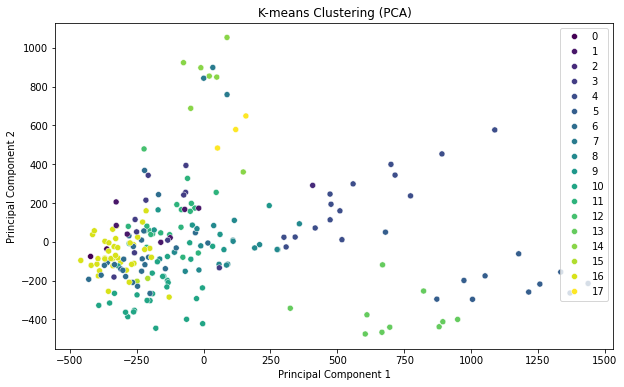

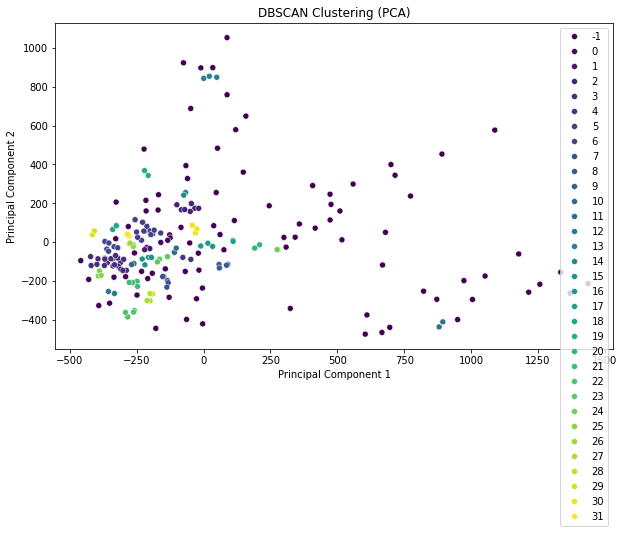

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_kmeans, palette='viridis', legend='full')
plt.title('K-means Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_dbscan, palette='viridis', legend='full')
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Analyze and evaluation:

In [10]:
homogeneity_kmeans = homogeneity_score(data['label'], cluster_labels_kmeans)
print(f"Homogeneity Score for K-means: {homogeneity_kmeans}")

silhouette_kmeans = silhouette_score(X, cluster_labels_kmeans)
print(f"Silhouette Score for K-means: {silhouette_kmeans}")

print ("★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★")

homogeneity_dbscan = homogeneity_score(data['label'], cluster_labels_dbscan)
print(f"Homogeneity Score for DBSCAN: {homogeneity_dbscan}")
silhouette_dbscan = silhouette_score(X_normalized, cluster_labels_dbscan)
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan}")


Homogeneity Score for K-means: 0.630222330346781
Silhouette Score for K-means: 0.01501963846385479
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
Homogeneity Score for DBSCAN: 0.38569751190481755
Silhouette Score for DBSCAN: 0.0032663072925060987


#### 8.Explain how to calculate silhouette and homogeneity criteria.

Silhoute scores is used to find the best number of clusters. It computes a value for each point, showing how similar the point is to the points in its cluster compared to other clusters. It has a range between -1 to 1. High values shows that points are in right clusters and do not belong to other clusters. Lower values inicates that we have too many or too few clusters; A silhoutte score of 0 means that the data point is on the border of two clusters indicating an ambiguous clustering.This method does not use labels and Only considers clustering results.For calculation a and b. a is the average distance of data point to all other data points in the same cluster. b is the minimum average distance of the data point to all other data points in any other cluster. The silhoutte score for the data point is the n given by formula:

s = (b - a) / max(a, b)


However homogenity score uses true labels. It measures what ratio of data truly in the same cluster are also in the same clusters in model's prediction. It has a range between 0 and 1 where 1 shows perfect match.This score is useful to check whether the clustering algorithm meets an important requirement: a cluster should contain only samples belonging to a single class.

#### 10.Suggest solutions to improve the performance of models

To enhance the performance of machine learning models, consider the following strategies:

Feature Engineering: Develop insightful features from raw data to provide more relevant information to the model. This can involve creating new features, transforming existing ones, or selecting the most informative features.

Hyperparameter Tuning: Optimize the model's hyperparameters using techniques like grid search, random search, or Bayesian optimization. Fine-tuning hyperparameters can significantly improve model performance.

Ensemble Learning: Combine multiple models to create a more robust and accurate predictor. Techniques such as bagging, boosting, and stacking can be employed to leverage the strengths of different models and mitigate individual weaknesses.

Cross-Validation: Use cross-validation techniques to assess model performance more accurately and prevent overfitting. K-fold cross-validation and stratified cross-validation are common approaches to validate model generalization.



                                                   🌌